In [2]:
import numpy as np
import pandas as pd
import janome
import matplotlib.pyplot as plt
import pickle
from janome.tokenizer import Tokenizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
#from imblearn.under_sampling import RandomUnderSampler

class WordDivider:
    def __init__(self):
        self.wakati = Tokenizer(wakati=True)
        self.t = Tokenizer()

    def wakati_words(self, text):
        if not text:
            return []

        words = []
        text = list(self.wakati.tokenize(text))
        for word in text:
            words.append(word)

        return words

    def surface_words(self, text):
        if not text:
            return []

        words = []
        for token in self.t.tokenize(text):
            words.append(token.base_form)
        return words

    def wakati_text(self, text):
        if not text:
            return []

        words = []
        wakati = list(self.wakati.tokenize(text))
        for word in wakati:
            words.append(word)

        output = ""
        for word in words:
            output += word
            output += " "
        return output

In [3]:
train = pd.read_csv("./experiment4_train.csv")
test = pd.read_csv("./experiment4_test.csv")
# train = pd.read_csv("./experiment5_train.csv", encoding="cp932")
# test = pd.read_csv("./experiment5_test.csv", encoding="cp932")
print(train["label"].value_counts())
print(test["label"].value_counts())
x_train, y_train = train.loc[:, "comment_sentence"].tolist(), train.loc[:, "label"].tolist()
x_test, y_test = test.loc[:, "comment_sentence"].tolist(), test.loc[:, "label"].tolist()
wd = WordDivider()
x_train = [wd.wakati_text(text) for text in x_train]
x_test = [wd.wakati_text(text) for text in x_test]

0.0    295
1.0    295
Name: label, dtype: int64
0.0    127
1.0    127
Name: label, dtype: int64


Test Accuracy: 0.665
Test Recall: 0.677
Test Precision: 0.662
Test f1-score: 0.669
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67       127
         1.0       0.67      0.65      0.66       127

    accuracy                           0.67       254
   macro avg       0.67      0.67      0.67       254
weighted avg       0.67      0.67      0.67       254



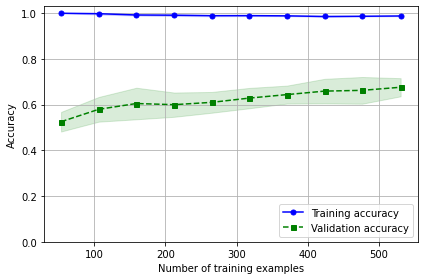

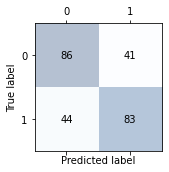

In [6]:
with open("model4.pickle", mode="rb") as f:
    lr_tfidf = pickle.load(f)
predict = lr_tfidf.predict(x_test)
print("Test Accuracy: %.3f" % accuracy_score(y_test, predict))
print("Test Recall: %.3f" % recall_score(y_test, predict, pos_label=0))
print("Test Precision: %.3f" % precision_score(y_test, predict, pos_label=0))
print("Test f1-score: %.3f" % f1_score(y_test, predict, pos_label=0))
print(classification_report(y_test, predict))

#学習曲線の可視化
train_sizes, train_scores, test_scores = learning_curve(estimator=lr_tfidf,
                                                       X=x_train, y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

# 混同行列の作成
predict = lr_tfidf.predict(x_test)
confmat = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [4]:
#誤分類データの抽出
false_predict_index = np.where(predict != y_test)
true_predict_index = np.where(predict == y_test)

false_x, false_y = [], []
for index in false_predict_index[0]:
    false_x.append(x_test[index])
    false_y.append(y_test[index])
false = pd.DataFrame(list(zip(false_x, false_y)), columns = ["comment", "label"])
false[false["label"] == 0]

true_x, true_y = [], []
for index in true_predict_index[0]:
    true_x.append(x_test[index])
    true_y.append(y_test[index])
true = pd.DataFrame(list(zip(true_x, true_y)), columns = ["comment", "label"])

true_0 = true[true["label"] == 0]
true_1 = true[true["label"] == 1]
false_0 = false[false["label"] == 0]
false_1 = false[false["label"] == 1]
true_1

,comment,label
0,かせる と 本質 が 不透明 に なり 、 お笑い の プロパガンダ 利用 倫理 観 欠如 ...,1.0
5,ワクチン の 手配 が 遅れ て いる と 聞い て い ます が ？,1.0
6,努力 の 量 が 圧倒的 だ よ ね,1.0
7,日本 国内 で も 感染 者 より 停泊 中 の 弁当 の 方 が 大きな ニュース に な...,1.0
8,これ 以上 国民 を 苦しめる な よ ！,1.0
...,...,...
158,おっしゃる 通り ！,1.0
160,過去 の 自分 に は ほっ か むりして,1.0
163,あまり ワクチン 接種 、 非 接種 で キツ い 表現 し ない 方 が いい です よ 。,1.0
165,そもそも 今 の 政治 体制 が 官僚 政治 という 事 に 疑問 を 感じる 、 まず そ...,1.0
